In [ ]:
# importing libraries

import numpy as np
import matplotlib.pyplot as plt
import os
import random
from tqdm import tqdm # for progress bar
import seaborn as sns

# Libraries for TensorFlow
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models, layers
from tensorflow import keras
import tensorflow as tf
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout,BatchNormalization,MaxPooling2D
from keras.models import Model


EPOCHS = 50
BATCH_SIZE = 60
VERBOSE = 1
N_HIDDEN=128
NB_CLASSES = 10
VALIDATION_SPLIT = 0.1

In [ ]:
# Loading dataset from keras

(xtrain,ytrain),(xtest,ytest)= keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
# Convert the images into 3 channels as MNIST images are Black and White so have 1 channel

xtrain=np.dstack([xtrain] * 3)
xtest=np.dstack([xtest]*3)
xtrain.shape,xtest.shape

((60000, 28, 84), (10000, 28, 84))

In [ ]:
# Reshape images as per the tensor format required by tensorflow

xtrain = xtrain.reshape(-1, 28,28,3)
xtest= xtest.reshape (-1,28,28,3)
xtrain.shape,xtest.shape


((60000, 28, 28, 3), (10000, 28, 28, 3))

In [ ]:
# Resize the images 48*48 as required by VGG16

from tensorflow.keras.utils import img_to_array, array_to_img

xtrain = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in xtrain])
xtest = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in xtest])
#train_x = preprocess_input(x)
xtrain.shape, xtest.shape

((60000, 48, 48, 3), (10000, 48, 48, 3))

In [ ]:
# Normalise the data and change data type
xtrain = xtrain / 255.
xtest = xtest / 255.
xtrain = xtrain.astype('float32')
xtest = xtest.astype('float32')

In [ ]:
ytrain = tf.keras.utils.to_categorical(ytrain, NB_CLASSES)
ytest = tf.keras.utils.to_categorical(ytest, NB_CLASSES)

In [ ]:
# Check properties of the model that we are going to use for Transfer Learning

print("Summary of default VGG16 model.\n")

# we are using VGG16 for transfer learnin here. So we have imported it
from tensorflow.keras.applications import VGG19

# initializing model with weights='imagenet'i.e. we are carring its original weights
model_vgg19=VGG19(weights='imagenet')

# display the summary to see the properties of the model
model_vgg19.summary()

Summary of default VGG16 model.

574710816/574710816 [==============================] - 3s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                           

In [ ]:
# Modelling WITH Transfer Learning
# Here we will prepare model as per our requirements


# let us prepare our input_layer to pass our image size. default is (224,224,3). we will change it to (224,224,3)
input_layer=layers.Input(shape=(48,48,3))
model = tf.keras.models.Sequential()

# initialize the transfer model VGG16 with appropriate properties per our need.
# we are passing paramers as following
# 1) weights='imagenet' - Using this we are carring weights as of original weights.
# 2) input_tensor to pass the VGG16 using input_tensor
# 3) we want to change the last layer so we are not including top layer
base_model=VGG19(weights='imagenet',input_tensor=input_layer,include_top=False)

# See the summary of the model with our properties.
base_model.summary()

80134624/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                              

In [ ]:
layer = base_model.layers
filters, biases = base_model.layers[1].get_weights()
print(layer[1].name, filters.shape)

block1_conv1 (3, 3, 3, 64)


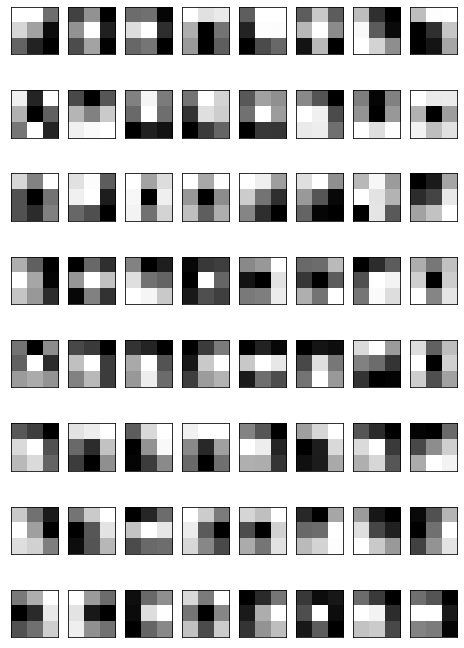

In [ ]:
fig1 = plt.figure(figsize=(8,12))
columns = 8
rows = 8
n_filters = rows * columns
for i in range(1, n_filters+1):
  f = filters[:, :, :, i-1]
  fig1 = plt.subplot(rows,columns,i)
  fig1.set_xticks([])
  fig1.set_yticks([])
  plt.imshow(f[:, :, 0], cmap='gray')
plt.show()



In [ ]:
conv_layer_index = [1, 2, 4]
outputs = [base_model.layers[i].output for i in conv_layer_index]
model_short = Model(inputs = base_model.inputs, outputs = outputs)
print(model_short.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
Total params: 112,576
Trainable params: 112,576
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
img = xtest[0]
img = np.expand_dims(img, 0)
feature_map = model.predict(img)[0]

1/1 [==============================] - 0s 138ms/step


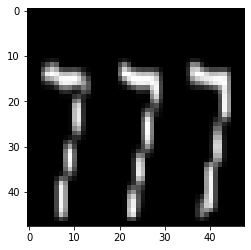

In [ ]:
# Visualize the feature map
plt.imshow(feature_map[:, :, 0], cmap='gray')
plt.show()

In [ ]:
#last_layer=model_vgg16.output # we are taking last layer of the model

# Add flatten layer: we are extending Neural Network by adding flattn layer


model.add(base_model)



model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(100, activation = 'relu'))
model.add(layers.Dense(10, activation = 'softmax'))


# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 100)               25700     
                                                                 
 dense_3 (Dense)             (None, 10)                1010      
                                                                 
Total params: 20,445,078
Trainable params: 20,445,078
No

In [ ]:
# we will freez all the layers except the last layer

# we are making all the layers intrainable except the last layer
for layer in base_model.layers:
    layer.trainable=False

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
history = model.fit(xtrain,ytrain,epochs=EPOCHS,batch_size=BATCH_SIZE,verbose=VERBOSE,validation_split=VALIDATION_SPLIT)


Epoch 1/50
900/900 [==============================] - 32s 27ms/step - loss: 0.3205 - accuracy: 0.8960 - val_loss: 0.1639 - val_accuracy: 0.9502
Epoch 2/50
900/900 [==============================] - 25s 28ms/step - loss: 0.1747 - accuracy: 0.9426 - val_loss: 0.1422 - val_accuracy: 0.9562
Epoch 3/50
900/900 [==============================] - 24s 27ms/step - loss: 0.1508 - accuracy: 0.9503 - val_loss: 0.1232 - val_accuracy: 0.9608
Epoch 4/50
900/900 [==============================] - 25s 27ms/step - loss: 0.1333 - accuracy: 0.9557 - val_loss: 0.1111 - val_accuracy: 0.9670
Epoch 5/50
900/900 [==============================] - 25s 27ms/step - loss: 0.1215 - accuracy: 0.9599 - val_loss: 0.1227 - val_accuracy: 0.9612
Epoch 6/50
900/900 [==============================] - 24s 27ms/step - loss: 0.1127 - accuracy: 0.9630 - val_loss: 0.1148 - val_accuracy: 0.9648
Epoch 7/50
900/900 [==============================] - 24s 27ms/step - loss: 0.1059 - accuracy: 0.9642 - val_loss: 0.1094 - val_accuracy:

In [ ]:
score= model.evaluate(xtest, ytest, verbose=VERBOSE)
print("\nTest Score:", score[0])
print('Test Accuracy:', score[1])

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['accuracy'], label ="train_accuracy")
plt.plot(history.history['val_accuracy'], label = "test_accuracy")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()




In [ ]:
model.predict(np.expand_dims(xtest[0], axis=0)).round(2)

In [ ]:
np.argmax(model.predict(np.expand_dims(xtest[0], axis=0)).round(2))

In [ ]:
Y_test = [np.argmax(label) for label in ytest]
Y_test[0]

In [ ]:
y_pred = model.predict(xtest).round(2)
y_pred

In [ ]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(16,9))
y_pred_labels = [np.argmax(label) for label in y_pred]
cm = confusion_matrix(Y_test, y_pred_labels)

sns.heatmap(cm, annot=True, fmt='d')